# STEPES-BD

https://sites.google.com/view/stepes-bd

**Autor: João Paulo dos Santos Mendes**
(joaopaulo164@gmail.com)

### Obtendo dados sobre os mortos pela COVID-19
Processo de Tratamento dos dados após obtenção deles do Bando de Dados/Blockchain do BigchainDB (MongoDB) via **Apache Spark**

In [20]:
#Carregando biblibotecas
sc = spark.sparkContext

In [21]:
#Carregando assets da Blockchain
assets_df = spark.read.json("~/../assets.json")

#Obtendo todos os Pacientes
pacientes_raw_df = assets_df.select("data.Paciente.*")
pacientes_raw_df.printSchema()

root
 |-- CPF: string (nullable = true)
 |-- Endereco: struct (nullable = true)
 |    |-- Bairro: string (nullable = true)
 |    |-- CEP: string (nullable = true)
 |    |-- Cidade: string (nullable = true)
 |    |-- Latitude: string (nullable = true)
 |    |-- Longitude: string (nullable = true)
 |    |-- Numero: string (nullable = true)
 |    |-- Rua: string (nullable = true)
 |    |-- UF: string (nullable = true)
 |-- FatorRH: string (nullable = true)
 |-- GrupoSanguineo: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- Nascimento: string (nullable = true)
 |-- Nome: string (nullable = true)
 |-- PrivateKey: string (nullable = true)
 |-- PublicKey: string (nullable = true)



In [22]:
#Tratando os dados dos pacientes
pacientes_df = pacientes_raw_df.select("Nome", "Nascimento").where("Nome is not Null")
pacientes_df.show()

+--------------------+----------+
|                Nome|Nascimento|
+--------------------+----------+
|      Aury Lucarelli|23/03/2015|
|  Apoliano Bergamini|21/11/1920|
|       Meria Almeida|11/05/1966|
|        Eudite Bueno|15/08/1992|
|      Claudian Rizza|18/09/1931|
|   Alexabdre Holanda|20/11/1927|
|    Marriete Camargo|16/01/1940|
|  Francimone Boscolo|25/07/1946|
|    Jessiani Boscolo|12/06/1941|
|   Leildes Carvalhal|17/04/1993|
|  Carliandra Almeida|09/05/2004|
|Christiany Gagliardi|04/11/1935|
|    Elonir Policarpo|20/05/1981|
|        Cilei Fabris|26/06/1977|
|      Zaneide Macedo|18/09/1934|
|    Ziene Di gennaro|17/02/1935|
|       Hiudy De rosa|19/09/1976|
|   Valdenilsa Cabral|07/09/1971|
|     Nazare Mendonça|07/01/1982|
|   Alexsadro Barbera|18/05/1924|
+--------------------+----------+
only showing top 20 rows



In [23]:
#Carregando metadata da Blockchain
df_metadata = spark.read.json("~/../metadata.json")

#Obtendo mortes por COVID-19
mortes_covid19_raw_df = df_metadata.select("metadata.*")
mortes_covid19_raw_df.printSchema()

root
 |-- COVID-19: struct (nullable = true)
 |    |-- Status: string (nullable = true)
 |    |-- Test: string (nullable = true)
 |-- CRM: string (nullable = true)
 |-- Causa_mortis: string (nullable = true)
 |-- Create_medical_record_date: string (nullable = true)
 |-- Data: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Medico: string (nullable = true)
 |-- Nome: string (nullable = true)
 |-- Paciente: string (nullable = true)
 |-- Transaction_date: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Unix_time: long (nullable = true)



In [24]:
#Tratando as morte por COVID-19 dos pacientes
mortes_covid19_df = mortes_covid19_raw_df.select("Nome", "Data", "Unix_time").where("Causa_mortis = 'COVID-19'")
mortes_covid19_df.show()

+----------------+--------------------+----------+
|            Nome|                Data| Unix_time|
+----------------+--------------------+----------+
|   Wedija Corona|30 de Março de 20...|1585607069|
|      Ralf Ebner|8 de Abril de 202...|1586385577|
|  Conceni Chiari|13 de Abril de 20...|1586817907|
|Queginaldo Lange|20 de Abril de 20...|1587423471|
|   Iviane Seixas|22 de Abril de 20...|1587596397|
|Eliany Cavaliere|22 de Abril de 20...|1587596429|
|  Moira Cecchini|25 de Abril de 20...|1587855990|
| Mathildes Ebner|27 de Abril de 20...|1588029014|
| Meirejane Tucci|27 de Abril de 20...|1588029026|
|Rondney Teixeira|27 de Abril de 20...|1588029033|
|Unbelina Santana|30 de Abril de 20...|1588289128|
|  Fabiao Queiroz|4 de Maio de 2020...|1588636006|
|   Thomais Nunes|4 de Maio de 2020...|1588636015|
|    Sand Ribeiro|4 de Maio de 2020...|1588636021|
|  Ramela Moreira|7 de Maio de 2020...|1588895658|
|  Evandil Barros|8 de Maio de 2020...|1588982509|
|   Rhebeca Feijó|11 de Maio de

In [25]:
# register the DataFrame como temp table
pacientes_df.registerTempTable("pacientes")
mortes_covid19_df.registerTempTable("mortes_covid19")

result = spark.sql("SELECT p.Nome, (TO_DATE(CAST(UNIX_TIMESTAMP(p.Nascimento, 'dd/mm/yyyy') AS TIMESTAMP))) as Nascimento, \
            (from_unixtime(cast(m.Unix_time as bigint),'yyyy-MM-dd')) as Morte\
          FROM pacientes p, mortes_covid19 m").where("p.Nome = m.Nome")
result.show()

+----------------+----------+----------+
|            Nome|Nascimento|     Morte|
+----------------+----------+----------+
|   Wedija Corona|2001-01-17|2020-03-30|
|      Ralf Ebner|1955-01-18|2020-04-08|
|  Conceni Chiari|1990-01-23|2020-04-13|
|Queginaldo Lange|1972-01-13|2020-04-20|
|   Iviane Seixas|1989-01-08|2020-04-22|
|Eliany Cavaliere|1944-01-15|2020-04-22|
|  Moira Cecchini|1967-01-14|2020-04-25|
|Rondney Teixeira|2002-01-06|2020-04-27|
| Meirejane Tucci|1957-01-16|2020-04-27|
| Mathildes Ebner|2003-01-14|2020-04-27|
|Unbelina Santana|1955-01-17|2020-04-30|
|    Sand Ribeiro|2019-01-26|2020-05-04|
|   Thomais Nunes|1920-01-04|2020-05-04|
|  Fabiao Queiroz|1987-01-19|2020-05-04|
|  Ramela Moreira|2016-01-22|2020-05-07|
|  Evandil Barros|1959-01-17|2020-05-09|
|   Rhebeca Feijó|2000-01-06|2020-05-12|
|Givaldina Araújo|1927-01-01|2020-05-15|
|Estephane D’urso|1985-01-26|2020-05-16|
|Istefany Marques|2009-01-15|2020-05-17|
+----------------+----------+----------+
only showing top

In [26]:
# register the DataFrame como temp tables
result.registerTempTable("result")
final_data = spark.sql("SELECT Nome,INT(datediff(to_date(Morte), to_date(Nascimento))/365) as Idade \
          FROM result")

# converter para Pandas Dataframe
final_data_pandas = final_data.orderBy("Idade").toPandas()
print(final_data_pandas)

                    Nome  Idade
0           Sand Ribeiro      1
1          Leovan Soeiro      3
2         Ramela Moreira      4
3          Edsom Peçanha      5
4    Cleivisson Trindade      8
5         Derliene Meira      9
6   Kalyandra Sanfilippo     10
7       Juciclei Mancuso     10
8            Zoni Padrão     10
9       Istefany Marques     11
10          Rigner Patti     13
11        Elenisio Borba     14
12            Hayna Dias     15
13       Mathildes Ebner     17
14           Geizy Naves     17
15      Rondney Teixeira     18
16         Wedija Corona     19
17     Andley Pellegrino     19
18         Rhebeca Feijó     20
19    Janderlene Milazzo     20
20      Cacildo Carlucci     20
21      Elizadra Guillén     21
22            Jesun Amor     22
23        Karielly Gioia     23
24        Conceni Chiari     30
25         Iviane Seixas     31
26          Arcido Costa     32
27        Fabiao Queiroz     33
28     Nereide Salvatori     33
29       Linique Serrano     34
..      

# Histograma (Histogram)
Um histograma é uma representação da distribuição de dados. Essa função chama matplotlib.pyplot.hist (), em cada série no DataFrame, resultando em um histograma por coluna.

## Histograma 1 (cada barra equivale a 2 anos)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff19dadcf28>]],
      dtype=object)

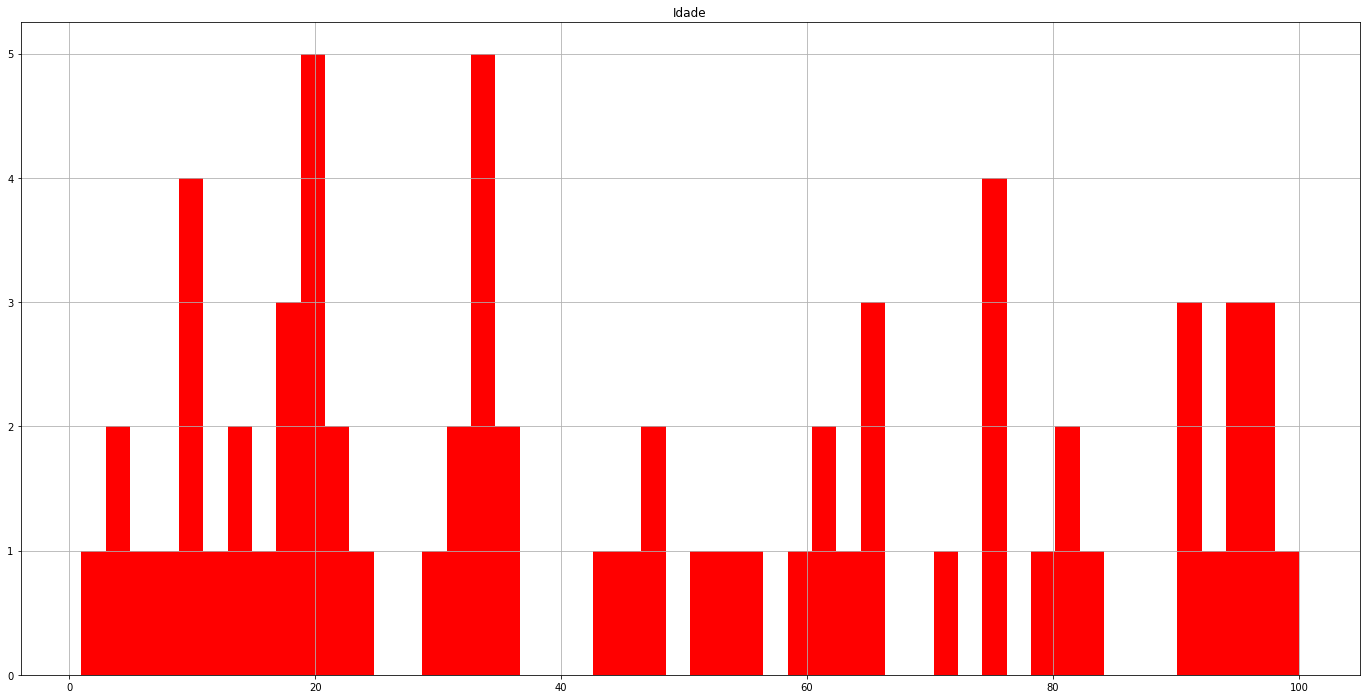

In [27]:
final_data_pandas[['Idade']].hist(bins=50, figsize=(24,12), color="red")

## Histograma 2 (cada barra equivale a 5 anos)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff19db38278>]],
      dtype=object)

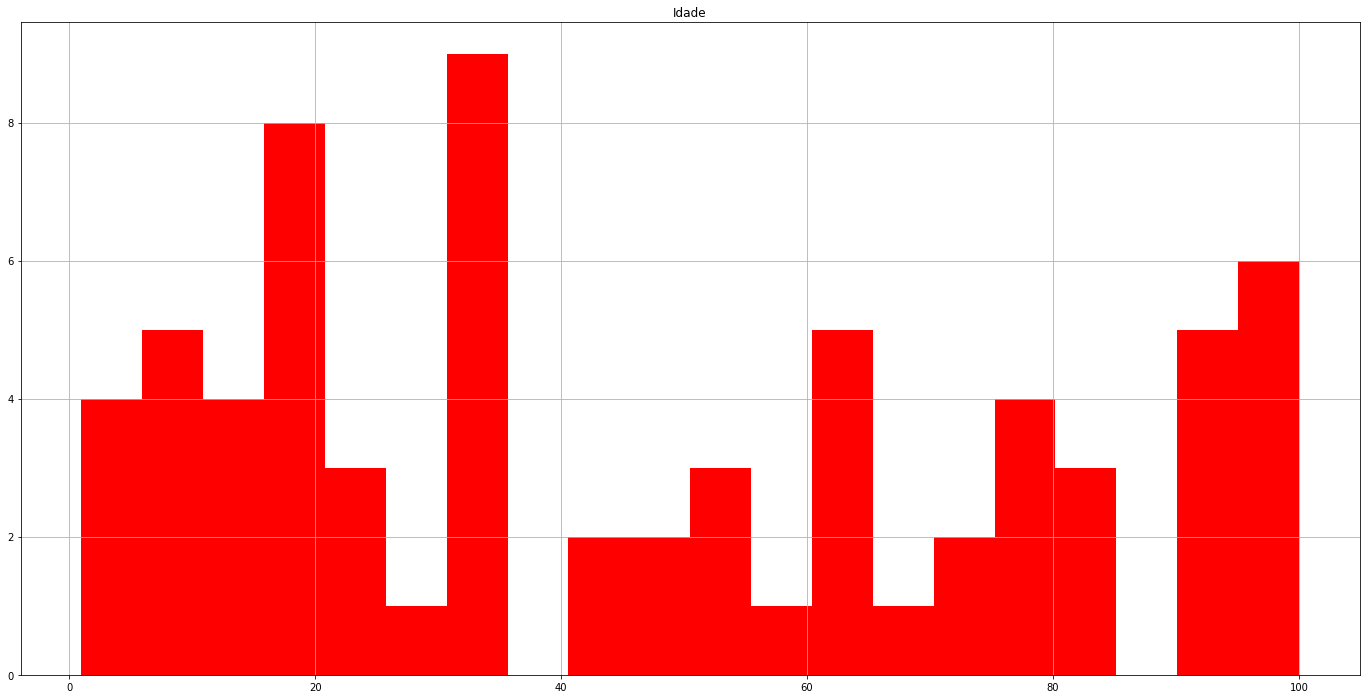

In [28]:
final_data_pandas[['Idade']].hist(bins=20, figsize=(24,12), color="red")

# Diagrama de caixa (Box plot)
Em estatística descritiva, diagrama de caixa, diagrama de extremos e quartis, boxplot ou box plot é uma ferramenta gráfica para representar a variação de dados observados de uma variável numérica por meio de quartis (ver figura 1, onde o eixo horizontal representa a variável). O boxplot tem uma reta (whisker ou fio de bigode) que estende–se verticalmente ou horizontalmente a partir da caixa, indicando a variabilidade fora do quartil superior e do quartil inferior.[1] Os valores atípicos ou outliers (valores discrepantes) podem ser plotados como pontos individuais.[2] O boxplot não é paramétrico, apresentando a variação em amostras de uma população estatística sem fazer qualquer suposição da distribuição estatística subjacente.[3] Os espaços entre as diferentes partes da caixa indicam o grau de dispersão, a obliquidade nos dados e os outliers.[4] O boxplot também permite estimar visualmente vários {\displaystyle L-}{\displaystyle L-}estimadores como amplitude interquartil, midhinge, range, mid-range, e trimean.[5] Em resumo, o boxplot identifica onde estão localizados 50% dos valores mais prováveis, a mediana e os valores extremos.[6]
https://pt.wikipedia.org/wiki/Diagrama_de_caixa

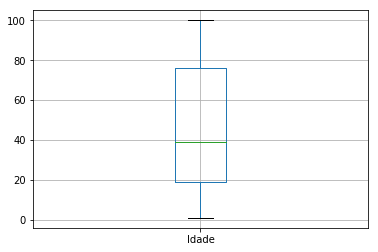

In [29]:
final_data_pandas.boxplot('Idade', showfliers=False)

In [30]:
final_data_pandas2 = final_data.groupBy("Idade").count().orderBy("Idade").where("Idade > 49").toPandas()
print(final_data_pandas2)

    Idade  count
0      52      1
1      53      1
2      55      1
3      60      1
4      61      2
5      63      1
6      65      2
7      66      1
8      72      1
9      75      1
10     76      3
11     79      1
12     82      2
13     84      1
14     91      2
15     92      1
16     93      1
17     95      1
18     96      2
19     98      3
20    100      1


# Gráfico de barras (Bar Plot)
Um gráfico de barras é um gráfico que apresenta dados categóricos com barras retangulares com comprimentos proporcionais aos valores que eles representam. Um gráfico de barras mostra comparações entre categorias discretas. Um eixo do gráfico mostra as categorias específicas sendo comparadas e o outro eixo representa um valor medido.

Text(0.5, 1.0, 'Mortes por Covid-19 (IDADE > 50 ANOS)')

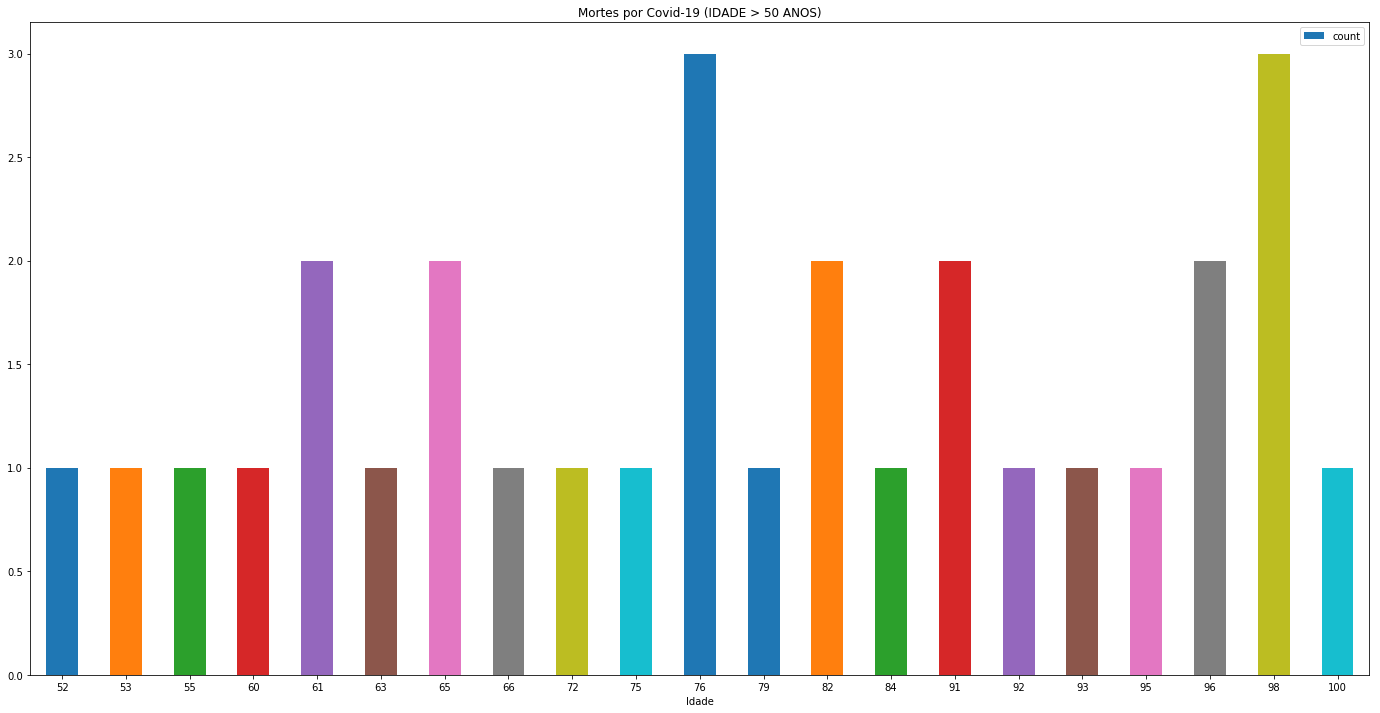

In [13]:
final_data_pandas2.plot.bar(x='Idade', y='count', rot=0, figsize=(24,12)).set_title('Mortes por Covid-19 (IDADE > 50 ANOS)')